#### **Telco Churn Prediction with Logistic Regression**

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from IPython.display import display
from ydata_profiling import ProfileReport # pip install pandas-profiling
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LinearRegression # For Variance Inflation Factor

# Dataset splitting
from sklearn.model_selection import train_test_split

# Data Processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import DictVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression

# Performance Metrics
from sklearn.metrics import accuracy_score, roc_curve, cohen_kappa_score, average_precision_score, recall_score

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 40

##### **I. Reading the dataset**

In [2]:
df = pd.read_csv(r"../dataset/telco_churn_raw.csv")
df.head()

Customer ID  Gender           Age Married Dependents  Number of Referrals  \
0  8779-QRDMV    Male  61 and above      No         No                    0   
1  7495-OOKFY  Female  61 and above     Yes        Yes                    1   
2  1658-BYGOY    Male  61 and above      No        Yes                    0   
3  4598-XLKNJ  Female  61 and above     Yes        Yes                    1   
4  4846-WHAFZ  Female  61 and above     Yes        Yes                    1   

   Tenure in Months Offer Phone Service  Avg Monthly Long Distance Charges  \
0                 1    No            No                               0.00   
1                 8   Yes           Yes                              48.85   
2                18   Yes           Yes                              11.33   
3                25   Yes           Yes                              19.76   
4                37   Yes           Yes                               6.33   

  Multiple Lines Internet Service  Avg Monthly GB Download Online Security  \
0             No              DSL                        8              No   
1            Yes      Fiber Optic                       17              No   
2            Yes      Fiber Optic                       52              No   
3             No      Fiber Optic                       12              No   
4            Yes      Fiber Optic                       14              No   

  Online Backup Device Protection Plan Premium Tech Support Streaming TV  \
0            No                    Yes                   No           No   
1           Yes                     No                   No           No   
2            No                     No                   No          Yes   
3           Yes                    Yes                   No          Yes   
4            No                     No                   No           No   

  Streaming Movies Streaming Music Unlimited Data        Contract  \
0              Yes              No             No  Month-to-Month   
1               No              No            Yes  Month-to-Month   
2              Yes             Yes            Yes  Month-to-Month   
3              Yes              No            Yes  Month-to-Month   
4               No              No            Yes  Month-to-Month   

  Paperless Billing   Payment Method  Monthly Charge  Total Charges  \
0               Yes  Bank Withdrawal           39.65          39.65   
1               Yes      Credit Card           80.65         633.30   
2               Yes  Bank Withdrawal           95.45        1752.55   
3               Yes  Bank Withdrawal           98.50        2514.50   
4               Yes  Bank Withdrawal           76.50        2868.15   

   Total Refunds  Total Extra Data Charges  Total Long Distance Charges  \
0           0.00                        20                         0.00   
1           0.00                         0                       390.80   
2          45.61                         0                       203.94   
3          13.43                         0                       494.00   
4           0.00                         0                       234.21   

   Total Revenue  Satisfaction Score  Churn Value  
0          59.65                   3            1  
1        1024.10                   3            1  
2        1910.88                   2            1  
3        2995.07                   2            1  
4        3102.36                   2            1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   object 
 3   Married                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Number of Referrals                7043 non-null   int64  
 6   Tenure in Months                   7043 non-null   int64  
 7   Offer                              7043 non-null   object 
 8   Phone Service                      7043 non-null   object 
 9   Avg Monthly Long Distance Charges  7043 non-null   float64
 10  Multiple Lines                     7043 non-null   object 
 11  Internet Service                   5517 non-null   objec

##### **II. Data cleaning**

**Converting binary columns**

In [4]:
# Converting 'Yes' and 'No' to binary 0 and 1
def binary_map(columns):
    return columns.map({"Yes": 1, "No": 0})

In [5]:
binary_list = [
    "Married",
    "Dependents",
    "Offer",
    "Phone Service",
    "Multiple Lines",
    "Online Security",
    "Online Backup",
    "Device Protection Plan",
    "Premium Tech Support",
    "Streaming TV",
    "Streaming Movies",
    "Streaming Music",
    "Unlimited Data",
    "Paperless Billing",
]
df[binary_list] = df[binary_list].apply(binary_map)

**Cleaning and standardizing texts**

In [6]:
# Making the column names consistent
df.columns = df.columns.str.replace(" ", "_").str.lower()

# Deleting the customer_id column
del df["customer_id"]

# We also clean the values of each categorical column
# making them lowercase and fixing the spaces
strings = list(df.dtypes[df.dtypes == "object"].index)

for col in strings:
    df[col] = df[col].str.lower().str.replace(" ", "_")

**Handling the misclassification of None under Internet Service as a missing value** 

In [7]:
# Converting the None category in internet_service to Not Applicable to as not be considered as missing value anymore

df["internet_service"] = df["internet_service"].replace({None: "Not Applicable"})
df["internet_service"]

0                  dsl
1          fiber_optic
2          fiber_optic
3          fiber_optic
4          fiber_optic
             ...      
7038    Not Applicable
7039             cable
7040       fiber_optic
7041               dsl
7042       fiber_optic
Name: internet_service, Length: 7043, dtype: object

In [8]:
df["internet_service"].value_counts(normalize=True)

internet_service
fiber_optic       0.430924
dsl               0.234559
Not Applicable    0.216669
cable             0.117848
Name: proportion, dtype: float64

In [9]:
df

gender           age  married  dependents  number_of_referrals  \
0       male  61_and_above        0           0                    0   
1     female  61_and_above        1           1                    1   
2       male  61_and_above        0           1                    0   
3     female  61_and_above        1           1                    1   
4     female  61_and_above        1           1                    1   
...      ...           ...      ...         ...                  ...   
7038  female  30_and_below        0           0                    0   
7039    male       31_-_60        1           1                    1   
7040  female  30_and_below        1           1                    4   
7041  female       31_-_60        1           1                    1   
7042    male       31_-_60        0           0                    0   

      tenure_in_months  offer  phone_service  \
0                    1      0              0   
1                    8      1              1   
2                   18      1              1   
3                   25      1              1   
4                   37      1              1   
...                ...    ...            ...   
7038                72      0              1   
7039                24      1              1   
7040                72      0              1   
7041                11      0              0   
7042                66      0              1   

      avg_monthly_long_distance_charges  multiple_lines internet_service  \
0                                  0.00               0              dsl   
1                                 48.85               1      fiber_optic   
2                                 11.33               1      fiber_optic   
3                                 19.76               0      fiber_optic   
4                                  6.33               1      fiber_optic   
...                                 ...             ...              ...   
7038                              22.77               0   Not Applicable   
7039                              36.05               1            cable   
7040                              29.66               1      fiber_optic   
7041                               0.00               0              dsl   
7042                              30.96               0      fiber_optic   

      avg_monthly_gb_download  online_security  online_backup  \
0                           8                0              0   
1                          17                0              1   
2                          52                0              0   
3                          12                0              1   
4                          14                0              0   
...                       ...              ...            ...   
7038                        0                0              0   
7039                       24                1              0   
7040                       59                0              1   
7041                       17                1              0   
7042                       11                1              0   

      device_protection_plan  premium_tech_support  streaming_tv  \
0                          1                     0             0   
1                          0                     0             0   
2                          0                     0             1   
3                          1                     0             1   
4                          0                     0             0   
...                      ...                   ...           ...   
7038                       0                     0             0   
7039                       1                     1             1   
7040                       1                     0             1   
7041                       0                     0             0   
7042                       1                     1             1   

      streaming_movies  streaming_music  unlimited_da

##### **III. Exploratory Data Analysis**

In [10]:
profile = ProfileReport(
    df,
    title="Telco Churn Dataset",
    html={"style": {"full_width": True}},
    dark_mode=True,
)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### **A. Numerical Variables**

#### **Checking for Multi-collinearity among Numerical  Variables using Variance Inflation Factor**

###### Thanks to Wei-Meng Lee's article on Medium entitled [Statistics in Python - Collinearity and Multicollinearity](https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f)

##### **Correlation vs. Collinearity vs. Multicollinearity**
If you recall, $correlation$ measures the strength and direction between two columns in your dataset. Correlation is often used to find the relationship between a feature and the target.

For example, if one of the features has a high correlation with the target, it tells you that this particular feature heavily influences the target and should be included when you are training the model.

$Collinearity$, on the other hand, is a situation where two features are linearly associated (high $correlation$), and they are used as predictors for the target.

Multicollinearity is a special case of collinearity where a feature exhibits a linear relationship with two or more features.

##### **Problem with collinearity and multicollinearity**

Recall the formula for multiple linear regression:

$$ y = w_{0} + w_{1}x_{1} + w_{2}x_{2} $$

One important assumption of linear regression is that there should exist a linear relationship between each of the predictors (x₁, x₂, etc) and the outcome y. However, if there is a correlation between the predictors (e.g. x₁ and x₂ are highly correlated), you can no longer determine the effect of one while holding the other constant since the two predictors change together. The end result is that the coefficients (w₁ and w₂) are now less exact and hence less interpretable.

##### **Fixing Multicollinearity**

When training a machine learning model, it is important that during the data preprocessing stage you sieve out the features in your dataset that exhibit multicollinearity. You can do so using a method known as VIF — Variance Inflation Factor.

VIF allows you to determine the strength of the correlation between the various independent variables. It is calculated by taking a variable and regressing it against every other variables.

VIF calculates how much the variance of a coefficient is inflated because of its linear dependencies with other predictors. Hence its name.

Here is how VIF works:

* Assuming you have a list of features — x₁, x₂, x₃, and x₄.
* You first take the first feature, x₁, and regress it against the other features:

$$ x_{1} \sim  x_{2} + x_{3} + x_{4} $$

* In the multiple regression above, you extract the R² value (between 0 and 1). If R² is large, this means that x₁ can be predicted from the three features, and is thus highly correlated with the three features — x₂, x₃, and x₄. If R² is small, this means that x₁ cannot be predicted from the features, and is thus not correlated with the three features — x₂, x₃, and x₄.

* Based on the R² value that is calculated for x₁, you can now calculate its VIF using the following formula:

$$ VIF = \frac {1} {1 - R^{2}} $$

* A large R² value (close to 1) will cause the denominator to be small (1 minus a value close to 1 will give you a number close to 0). This will result in a large VIF. A large VIF indicates that this feature exhibits multicollinearity with the other features.

* Conversely, a small R² value (close to 0) will cause the denominator to be large (1 minus a value close to 0 will give you a number close to 1). This will result in a small VIF. A small VIF indicates that this feature exhibits low multicollinearity with the other features.

* $ 1 - R^{2} $ is called tolerance.
* You repeat the process above for the other features and calculate the VIF for each features:

`x₂ ~ x₁ + x₃ + x₄`   # regress x₂ against the rest of the features

`x₃ ~ x₁ + x₂ + x₄`   # regress x₃ against the rest of the features

`x₄ ~ x₁ + x₂ + x₃`   # regress x₄ against the rest of the features

While correlation matrix and scatter plots can be used to find multicollinearity, they only show the bivariate relationship between the independent variables. VIF ,on the other hand, shows the correlation of a variable with a group of other variables.

In [11]:
all_numericals = [
    "number_of_referrals",
    "tenure_in_months",
    "avg_monthly_long_distance_charges",
    "avg_monthly_gb_download",
    "monthly_charge",
    "total_charges",
    "total_refunds",
    "total_extra_data_charges",
    "total_long_distance_charges",
    "total_revenue",
]
all_numericals

['number_of_referrals',
 'tenure_in_months',
 'avg_monthly_long_distance_charges',
 'avg_monthly_gb_download',
 'monthly_charge',
 'total_charges',
 'total_refunds',
 'total_extra_data_charges',
 'total_long_distance_charges',
 'total_revenue']

##### **Calculating VIF**
Now that you have identified the columns that you want to use for training your model, you need to see which of the columns have multicollinearity. So so let’s use our calculate_vif() function.

In [12]:
# Checking for multi-collinearity among numerical variables
def calculate_vif(df, features):
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)

        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1 / (tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({"VIF": vif, "Tolerance": tolerance, "R2": r2})

In [13]:
numerical_feats = calculate_vif(df=df, features=all_numericals)
numerical_feats

C:\Users\acer\AppData\Local\Temp\ipykernel_36120\1000163190.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1 / (tolerance[feature])
C:\Users\acer\AppData\Local\Temp\ipykernel_36120\1000163190.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1 / (tolerance[feature])
C:\Users\acer\AppData\Local\Temp\ipykernel_36120\1000163190.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1 / (tolerance[feature])
C:\Users\acer\AppData\Local\Temp\ipykernel_36120\1000163190.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1 / (tolerance[feature])
C:\Users\acer\AppData\Local\Temp\ipykernel_36120\1000163190.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1 / (tolerance[feature])


VIF  Tolerance   R2
number_of_referrals                1.127920   0.886588  1.0
tenure_in_months                   7.466171   0.133937  1.0
avg_monthly_long_distance_charges  2.835201   0.352709  1.0
avg_monthly_gb_download            1.201399   0.832363  1.0
monthly_charge                     3.524745   0.283708  1.0
total_charges                           inf   0.000000  1.0
total_refunds                           inf   0.000000  1.0
total_extra_data_charges                inf   0.000000  1.0
total_long_distance_charges             inf   0.000000  1.0
total_revenue                           inf   0.000000  1.0

##### **Interpreting VIF Values**

The valid value for VIF ranges from 1 to infinity. A rule of thumb for interpreting VIF values is:

* 1 — features are not correlated
* 1<VIF<5 — features are moderately correlated
* VIF>5 — features are highly correlated
* VIF>10 — high correlation between features and is cause for concern

From the result calculating the VIF in the previous section, you can see that the following features has a a VIF value of infinity:
- `total_charges`
- `total_refunds`
- `total_extra_data_charges`
- `total_long_distance_charges`
- `total_revenue`. 

This means that these features are highly correlated with a linear relationship with each other. 

Let's remove these 5 highly correlated features and see if the result for VIF improves.

In [14]:
numerical = [
    "number_of_referrals",
    "tenure_in_months",
    "avg_monthly_long_distance_charges",
    "avg_monthly_gb_download",
    "monthly_charge",
]

In [15]:
non_collinear_feats = calculate_vif(df=df, features=numerical)
non_collinear_feats

VIF  Tolerance        R2
number_of_referrals                1.126569   0.887651  0.231554
tenure_in_months                   1.202330   0.831719  0.231554
avg_monthly_long_distance_charges  1.029305   0.971529  0.231554
avg_monthly_gb_download            1.198564   0.834332  0.231554
monthly_charge                     1.301328   0.768446  0.231554

Now, the VIF for all features are almost the same in the range of 1. We can say that the remaining features we have are not correlated with each other. This means that if we take them as predictors for our target variable, their effects will be independent of each other.

In [16]:
non_collinear_feats.index

Index(['number_of_referrals', 'tenure_in_months',
       'avg_monthly_long_distance_charges', 'avg_monthly_gb_download',
       'monthly_charge'],
      dtype='object')

We can further inspect which among these non-collinear numerical features have the highest correlation with our target variable. We can find their score through `SelectKBest`.

In [17]:
from sklearn.feature_selection import SelectKBest

fs = SelectKBest(k="all")
fs.fit(df[non_collinear_feats.index], df.churn_value)

SelectKBest(k='all')

Feature number_of_referrals: 629.8157131699645
Feature tenure_in_months: 1001.3628274161512
Feature avg_monthly_long_distance_charges: 0.4642208509360131
Feature avg_monthly_gb_download: 16.85442224036058
Feature monthly_charge: 273.4637042077079


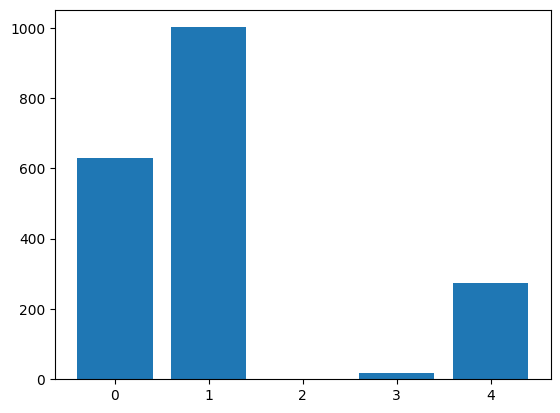

In [18]:
# what are scores for the features
for i in range(len(fs.scores_)):
    print(f"Feature {non_collinear_feats.index[i]}: {fs.scores_[i]}")
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Based on our results, `tenure_in_months` has the highest effect on the churn value, followed by the `number_of_referrals`.`monthly_charge` has a somehat less effect on the churn value, while both the `avg_monthly_long_distance_charges` and the `avg_monthly_gb_download` have little to no effect. We can decide whether to remove the latter two from our features, based on the performance of our model after training. For now, we will keep them because the model still can learn from these features, either increasing or decreasing its generalization performance.

#### **B. Categorical Variables**

In [19]:
# Inspecting the relationship between each categorical variable with target churn
categorical = [
    "gender",
    "age",
    "married",
    "offer",
    "phone_service",
    "multiple_lines",
    "internet_service",
    "online_security",
    "online_backup",
    "device_protection_plan",
    "premium_tech_support",
    "streaming_tv",
    "streaming_movies",
    "streaming_music",
    "unlimited_data",
    "contract",
    "paperless_billing",
    "payment_method",
    "dependents",
    "satisfaction_score",
]

#### **Calculating the *Risk-ratio***

Risk-ratio describes the ratio between the mean of each category and the global churn rate. A risk-ratio greater than 1 means that that category is more likely to churn, and a risk-ratio of less than 1 is less likely to churn.

In [20]:
global_churn_rate = df.churn_value.mean()

for c in categorical:
    print(c)
    df_group = df.groupby(c).churn_value.agg(["mean", "count"])
    df_group["diff"] = df_group["mean"] - global_churn_rate
    df_group["risk"] = df_group["mean"] / global_churn_rate
    display(df_group)
    print()

gender


mean  count      diff      risk
gender                                     
female  0.269209   3488  0.003839  1.014466
male    0.261603   3555 -0.003766  0.985807


age


mean  count      diff      risk
age                                              
30_and_below  0.223676   1529 -0.041694  0.842882
31_-_60       0.239097   3852 -0.026273  0.900994
61_and_above  0.364621   1662  0.099251  1.374010


married


mean  count      diff      risk
married                                     
0        0.329580   3641  0.064210  1.241964
1        0.196649   3402 -0.068721  0.741038


offer


mean  count      diff      risk
offer                                     
0      0.271086   3877  0.005716  1.021540
1      0.258370   3166 -0.007000  0.973623


phone_service


mean  count      diff      risk
phone_service                                     
0              0.249267    682 -0.016103  0.939319
1              0.267096   6361  0.001726  1.006506


multiple_lines


mean  count      diff      risk
multiple_lines                                     
0               0.250246   4072 -0.015124  0.943007
1               0.286099   2971  0.020729  1.078114


internet_service


mean  count      diff      risk
internet_service                                     
Not Applicable    0.074050   1526 -0.191320  0.279044
cable             0.256627    830 -0.008743  0.967052
dsl               0.185835   1652 -0.079535  0.700288
fiber_optic       0.407249   3035  0.141879  1.534646


online_security


mean  count      diff      risk
online_security                                     
0                0.313296   5024  0.047926  1.180602
1                0.146112   2019 -0.119258  0.550597


online_backup


mean  count      diff      risk
online_backup                                     
0              0.291721   4614  0.026351  1.099299
1              0.215315   2429 -0.050055  0.811377


device_protection_plan


mean  count      diff      risk
device_protection_plan                                     
0                       0.286518   4621  0.021148  1.079693
1                       0.225021   2422 -0.040349  0.847951


premium_tech_support


mean  count      diff      risk
premium_tech_support                                     
0                     0.311862   4999  0.046493  1.175199
1                     0.151663   2044 -0.113706  0.571517


streaming_tv


mean  count      diff      risk
streaming_tv                                     
0             0.243312   4336 -0.022058  0.916878
1             0.300702   2707  0.035332  1.133143


streaming_movies


mean  count      diff      risk
streaming_movies                                     
0                 0.243795   4311 -0.021575  0.918699
1                 0.299414   2732  0.034044  1.128291


streaming_music


mean  count      diff      risk
streaming_music                                     
0                0.250494   4555 -0.014876  0.943943
1                0.292605   2488  0.027235  1.102629


unlimited_data


mean  count      diff      risk
unlimited_data                                     
0               0.159704   2298 -0.105666  0.601817
1               0.316544   4745  0.051174  1.192840


contract


mean  count      diff      risk
contract                                           
month-to-month  0.458449   3610  0.193079  1.727584
one_year        0.107097   1550 -0.158273  0.403575
two_year        0.025491   1883 -0.239879  0.096059


paperless_billing


mean  count      diff      risk
paperless_billing                                     
0                  0.163301   2872 -0.102069  0.615371
1                  0.335651   4171  0.070281  1.264842


payment_method


mean  count      diff      risk
payment_method                                      
bank_withdrawal  0.339985   3909  0.074615  1.281173
credit_card      0.144780   2749 -0.120590  0.545578
mailed_check     0.368831    385  0.103461  1.389876


dependents


mean  count      diff      risk
dependents                                     
0           0.325517   5416  0.060147  1.226654
1           0.065151   1627 -0.200219  0.245509


satisfaction_score


mean  count      diff      risk
satisfaction_score                                     
1                   1.000000    922  0.734630  3.768325
2                   1.000000    518  0.734630  3.768325
3                   0.160976   2665 -0.104394  0.606608
4                   0.000000   1789 -0.265370  0.000000
5                   0.000000   1149 -0.265370  0.000000

With the table of results above for each category, we can see the individual risk-ratio of each category in each categorical feature. However, we may want to see the importance of each categorical feature as a whole to our target variable.

#### **Feature importance: Mutual information**

Mutual information tells us how much we can learn about one variable, if we know the value of another.

In [21]:
# Checking for the Mutual Information between each categorical value with our target variable `churn_value`.
# In the code below, we will find the top categorical features which give us the most information about our target variable churn.
mutual_info = (
    df[categorical]
    .apply(lambda series: mutual_info_score(series, df.churn_value))
    .sort_values(ascending=False)
    .to_frame(name="importance")
)
mutual_info

importance
satisfaction_score        0.411622
contract                  0.118437
internet_service          0.050432
dependents                0.037746
payment_method            0.025417
paperless_billing         0.019194
online_security           0.015885
unlimited_data            0.014743
premium_tech_support      0.014608
married                   0.011454
age                       0.007570
online_backup             0.003460
device_protection_plan    0.002228
streaming_tv              0.001981
streaming_movies          0.001868
streaming_music           0.001030
multiple_lines            0.000801
offer                     0.000103
phone_service             0.000072
gender                    0.000037

In the end, we decide to keep only those variables with a mutual information score greater than or equal to 0.001. All other variables which have a score less than our chosen threshold means that we cannot learn enough information from them about our target variable.

In [22]:
related_cats = list(mutual_info[mutual_info.importance >= 0.001].index)
related_cats

['satisfaction_score',
 'contract',
 'internet_service',
 'dependents',
 'payment_method',
 'paperless_billing',
 'online_security',
 'unlimited_data',
 'premium_tech_support',
 'married',
 'age',
 'online_backup',
 'device_protection_plan',
 'streaming_tv',
 'streaming_movies',
 'streaming_music']

Let us shrink down our original dataframe to only contain the numerical and categorical columns we need.

In [23]:
df_cleaned = df.copy()
df_cleaned = df_cleaned[numerical + related_cats]
df_cleaned["churn"] = df.churn_value
df_cleaned

number_of_referrals  tenure_in_months  \
0                       0                 1   
1                       1                 8   
2                       0                18   
3                       1                25   
4                       1                37   
...                   ...               ...   
7038                    0                72   
7039                    1                24   
7040                    4                72   
7041                    1                11   
7042                    0                66   

      avg_monthly_long_distance_charges  avg_monthly_gb_download  \
0                                  0.00                        8   
1                                 48.85                       17   
2                                 11.33                       52   
3                                 19.76                       12   
4                                  6.33                       14   
...                                 ...                      ...   
7038                              22.77                        0   
7039                              36.05                       24   
7040                              29.66                       59   
7041                               0.00                       17   
7042                              30.96                       11   

      monthly_charge  satisfaction_score        contract internet_service  \
0              39.65                   3  month-to-month              dsl   
1              80.65                   3  month-to-month      fiber_optic   
2              95.45                   2  month-to-month      fiber_optic   
3              98.50                   2  month-to-month      fiber_optic   
4              76.50                   2  month-to-month      fiber_optic   
...              ...                 ...             ...              ...   
7038           21.15                   5        two_year   Not Applicable   
7039           84.80                   3        one_year            cable   
7040          103.20                   4        one_year      fiber_optic   
7041           29.60                   4  month-to-month              dsl   
7042          105.65                   4        two_year      fiber_optic   

      dependents   payment_method  paperless_billing  online_security  \
0              0  bank_withdrawal                  1                0   
1              1      credit_card                  1                0   
2              1  bank_withdrawal                  1                0   
3              1  bank_withdrawal                  1                0   
4              1  bank_withdrawal                  1                0   
...          ...              ...                ...              ...   
7038           0  bank_withdrawal                  1                0   
7039           1     mailed_check                  1                1   
7040           1      credit_card                  1                0   
7041           1  bank_withdrawal                  1                1   
7042           0  bank_withdrawal                  1                1   

      unlimited_data  premium_tech_support  married           age  \
0                  0                     0        0  61_and_above   
1                  1                     0        1  61_and_above   
2                  1                     0        0  61_and_above   
3                  1                     0        1  61_and_above   
4                  1                     0        1  61_and_above   
...              ...                   ...      ...           ...   
7038               0                     0        0  30_and_below   
7039               1                     1        1       31_-_60   
7040               1                     0        1  30_and_below   
7041               1                     0        1       31_-_60   
7042               1                     1        0       31_-_

##### **IV. Setting up the validation framework**

We first divide the dataset into 80-20, which allocates 20% for the test set.

In [24]:
df_cleaned.churn.value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Since we have an imbalance distribution of values in our target variable, we want to maintain this state in our splits.

Our target variable is roughly distributed into 70-30. Since our categories are not balanced, we need to `stratify` it to maintain the original distribution in our splitted sets.

In [25]:
df_full_train, df_test = train_test_split(
    df_cleaned, test_size=0.2, random_state=1, stratify=df_cleaned.churn
)

In [26]:
len(df_full_train), len(df_test)

(5634, 1409)

In [27]:
df_full_train.churn.value_counts(normalize=True)

churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

We maintained the proportional imbalance of our target after we applied the split. We have to apply `stratify` again as we split `full_train` into `train` and `val`.

We divide the 80% into two, 60% for train, and 20% for val.

It means that the value we will pass to the test_size parameter is 0.25, because we want to assign one-fourth of it for validation.

In [28]:
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=1, stratify=df_full_train.churn
)

Checking the length of our train, validation, and test sets.

In [29]:
print(f"Length of Train dataset: {len(df_train)}")
print(f"Length of Validation dataset: {len(df_val)}")
print(f"Length of Test dataset: {len(df_test)}")

Length of Train dataset: 4225
Length of Validation dataset: 1409
Length of Test dataset: 1409


It is also useful to reset the indices of records on the three datasets.

In [30]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Let's separate the target column from the rest of our features.

In [31]:
y_full_train = df_full_train.churn.values
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [32]:
# Delete the target variable from the features dataset
del df_full_train["churn"]
del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

In [33]:
df_train.columns

Index(['number_of_referrals', 'tenure_in_months',
       'avg_monthly_long_distance_charges', 'avg_monthly_gb_download',
       'monthly_charge', 'satisfaction_score', 'contract', 'internet_service',
       'dependents', 'payment_method', 'paperless_billing', 'online_security',
       'unlimited_data', 'premium_tech_support', 'married', 'age',
       'online_backup', 'device_protection_plan', 'streaming_tv',
       'streaming_movies', 'streaming_music'],
      dtype='object')

##### **V. Data Preprocessing**

**Applying MinMaxScaler on numerical variables**

In [34]:
scaler = MinMaxScaler()
nums = df_train[numerical].values
num_scaled = scaler.fit_transform(nums)

In [35]:
data_values = np.column_stack([num_scaled, df_train[related_cats].values])
column_names = numerical + related_cats
df_train_scaled = pd.DataFrame(data_values, columns=column_names)
df_train_scaled

number_of_referrals tenure_in_months avg_monthly_long_distance_charges  \
0                    0.9         0.943662                               0.0   
1                    0.0         0.394366                          0.020404   
2                    0.0         0.098592                               0.0   
3                    0.0         0.126761                          0.913983   
4                    1.0         0.816901                          0.084217   
...                  ...              ...                               ...   
4220                 0.0         0.746479                          0.152831   
4221                 0.0         0.140845                          0.929986   
4222                 0.1         0.901408                          0.904381   
4223                 0.0         0.042254                          0.130026   
4224                 0.1          0.28169                          0.436687   

     avg_monthly_gb_download monthly_charge satisfaction_score  \
0                   0.329412       0.234679                  3   
1                   0.223529        0.50274                  1   
2                   0.188235       0.068261                  3   
3                   0.211765       0.660688                  1   
4                   0.247059       0.643249                  4   
...                      ...            ...                ...   
4220                0.035294       0.612357                  4   
4221                     0.0       0.015944                  4   
4222                0.223529       0.920777                  3   
4223                0.858824       0.615346                  3   
4224                0.694118       0.873941                  1   

            contract internet_service dependents   payment_method  \
0           two_year            cable          0  bank_withdrawal   
1     month-to-month              dsl          0  bank_withdrawal   
2     month-to-month            cable          0      credit_card   
3     month-to-month      fiber_optic          0     mailed_check   
4           one_year      fiber_optic          0      credit_card   
...              ...              ...        ...              ...   
4220  month-to-month      fiber_optic          0  bank_withdrawal   
4221        one_year   Not Applicable          0      credit_card   
4222        two_year      fiber_optic          1      credit_card   
4223  month-to-month      fiber_optic          0  bank_withdrawal   
4224  month-to-month      fiber_optic          0  bank_withdrawal   

     paperless_billing online_security unlimited_data premium_tech_support  \
0                    1               1              1                    0   
1                    1               1              1                    0   
2                    1               0              1                    0   
3                    1               1              1                    0   
4                    1               1              1                    0   
...                ...             ...            ...                  ...   
4220                 1               0              1                    0   
4221                 0               0              0                    0   
4222                 1               0              1                    1   
4223                 1               1              1                    0   
4224                 1               0              1                    1   

     married           age online_backup device_protection_plan streaming_tv  \
0          1  61_and_above             1                      1            0   
1          0       31_-_60             1                      1            0   
2          0       31_-_60             0                      0            0   
3          0       31_-_60             0                      0            1   
4          1  61_and_above             1                      1            0   
...      ...     

In [36]:
df_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   number_of_referrals                4225 non-null   object
 1   tenure_in_months                   4225 non-null   object
 2   avg_monthly_long_distance_charges  4225 non-null   object
 3   avg_monthly_gb_download            4225 non-null   object
 4   monthly_charge                     4225 non-null   object
 5   satisfaction_score                 4225 non-null   object
 6   contract                           4225 non-null   object
 7   internet_service                   4225 non-null   object
 8   dependents                         4225 non-null   object
 9   payment_method                     4225 non-null   object
 10  paperless_billing                  4225 non-null   object
 11  online_security                    4225 non-null   object
 12  unlimi

##### **Onehot encoding nominal variables with DictVectorizer**

**DictVectorizer** is a convenient tool to onehot-encode nominal variables. We can pass to it a dictionary of all our records, which may contain numerical, nominal, and ordinal variables. The good thing is, it will only onehot-encode the nominal ones, and leave the numerical and ordinal variables. 

Note: The ordinal variables must already be in $discrete$ form for it to be left out.

In [37]:
# Creating a list of dictionaries which contain every record by row
# Every column name is the key, and the value is its value for that column per record
train_dicts = df_train_scaled.to_dict(orient="records")
train_dicts[0]

{'number_of_referrals': 0.9,
 'tenure_in_months': 0.943661971830986,
 'avg_monthly_long_distance_charges': 0.0,
 'avg_monthly_gb_download': 0.32941176470588235,
 'monthly_charge': 0.23467862481315402,
 'satisfaction_score': 3,
 'contract': 'two_year',
 'internet_service': 'cable',
 'dependents': 0,
 'payment_method': 'bank_withdrawal',
 'paperless_billing': 1,
 'online_security': 1,
 'unlimited_data': 1,
 'premium_tech_support': 0,
 'married': 1,
 'age': '61_and_above',
 'online_backup': 1,
 'device_protection_plan': 1,
 'streaming_tv': 0,
 'streaming_movies': 0,
 'streaming_music': 0}

In [38]:
# Creating a DictVectorizer object
dv = DictVectorizer(sparse=False)

# Fitting our train dictionary to our Dictvectorizer
dv.fit(train_dicts)

# Checking feature names of of the Dictvectorizer
print(dv.get_feature_names_out())

# Transforming our features to become our X_train
X_train = dv.transform(train_dicts)

# Creating a list of dictionaries of records of df_val
nums_val = df_val[numerical].values
nums_val_scaled = scaler.transform(nums_val)

data_values_val = np.column_stack([nums_val_scaled, df_val[related_cats].values])
column_names = numerical + related_cats
df_val_scaled = pd.DataFrame(data_values_val, columns=column_names)

val_dicts = df_val_scaled.to_dict(orient="records")
# Transforming features to become our X_val
X_val = dv.transform(val_dicts)

['age=30_and_below' 'age=31_-_60' 'age=61_and_above'
 'avg_monthly_gb_download' 'avg_monthly_long_distance_charges'
 'contract=month-to-month' 'contract=one_year' 'contract=two_year'
 'dependents' 'device_protection_plan' 'internet_service=Not Applicable'
 'internet_service=cable' 'internet_service=dsl'
 'internet_service=fiber_optic' 'married' 'monthly_charge'
 'number_of_referrals' 'online_backup' 'online_security'
 'paperless_billing' 'payment_method=bank_withdrawal'
 'payment_method=credit_card' 'payment_method=mailed_check'
 'premium_tech_support' 'satisfaction_score' 'streaming_movies'
 'streaming_music' 'streaming_tv' 'tenure_in_months' 'unlimited_data']


##### **VI. Training the model**

**Logistic Regression**

In general, supervised models follow can be represented with this formula:

$$ g(x_{i}) = y_{i} $$ 
$$ g(x_{i}) = b + w^{T} \cdot x_{i}

Depending on what is the type of target variable, the supervised task can be regression or classification (binary or multiclass). Binary classification tasks can have negative (0) or positive (1) target values. The output of these models is the probability of $xi$ belonging to the positive class.

Logistic regression is similar to linear regression because both models take into account the bias term and weighted sum of features. The difference between these models is that the output of linear regression is a real number, while logistic regression outputs a value between zero and one, applying the sigmoid function to the linear regression formula.

$$ z = b + w^{T} \cdot x_{i} $$

$\text{Sigmoid function:}$
$$ g(x_{i})  = \frac {1} {1 + e^{-z}}   $$

In [39]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

<em>Looking at the weights. </em>   `model.coef_` actually gives a 2-D array with 1 record which is the row of weights, that's why `[0]` was used in the code below. We can also use .`ravel()` to flatten the array.

In [40]:
model.coef_[0].round(3)

array([-0.219, -0.264,  0.486,  0.059,  0.076,  0.975,  0.103, -1.076,
       -1.599,  0.057, -0.347,  0.188, -0.014,  0.175,  0.954,  0.747,
       -3.774, -0.177, -2.213,  0.324,  0.069, -0.409,  0.342, -0.702,
       -5.585, -0.026,  0.42 ,  0.286, -1.435, -0.15 ])

<em>Looking at the bias term. </em> `model.intercept_` actually gives a 1-D array with 1 record, that's why `[0]` was used to capture only the bias element.

In [41]:
model.intercept_[0]

15.426832586101009

The function `model.predict_proba()` gives a 2-D array of "soft prediction". 

It means that we get the exact probability resulting from the prediction. The first column is the probability that the churn value for that record will be 0, and the second column is the probability that its churn value will be 1. 

We just need the second column, as shown by the code below.

In [42]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([9.99993126e-01, 5.73962621e-04, 1.81274972e-05, ...,
       6.11541947e-01, 6.22984416e-01, 4.24943127e-01])

Checking for the accuracy of the model. Though accuracy is **only to be used for balanced dataset**, we will use other classification performance metrics to gauge our model better later.

In [43]:
t = 0.45
df_pred = pd.DataFrame()
df_pred["probability"] = y_pred
df_pred["actual"] = y_val
df_pred["prediction"] = (y_pred >= t).astype(int)
df_pred["correct"] = df_pred.prediction == df_pred.actual
df_pred

probability  actual  prediction  correct
0     9.999931e-01       1           1     True
1     5.739626e-04       0           0     True
2     1.812750e-05       0           0     True
3     3.423704e-09       0           0     True
4     5.433727e-07       0           0     True
...            ...     ...         ...      ...
1404  1.527989e-01       0           0     True
1405  5.040107e-06       0           0     True
1406  6.115419e-01       1           1     True
1407  6.229844e-01       1           1     True
1408  4.249431e-01       0           0     True

[1409 rows x 4 columns]

In [44]:
df_pred.correct.mean()

0.9616749467707594

We have a `96.17%` accuracy on our validation dataset.

A shortcut for finding the accuracy of our prediction.

In [45]:
(y_val == (y_pred >= t).astype(int)).mean()

0.9616749467707594

##### **VII. Model Interpretation**

Let us make sense of the coefficients we got after training the model.

Let us combine the feature with its corresponding weight. We will use `zip` function to combine each of them as a tuple respectively. Next, we will turn the zip into a dictionary.

In [46]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'age=30_and_below': -0.219,
 'age=31_-_60': -0.264,
 'age=61_and_above': 0.486,
 'avg_monthly_gb_download': 0.059,
 'avg_monthly_long_distance_charges': 0.076,
 'contract=month-to-month': 0.975,
 'contract=one_year': 0.103,
 'contract=two_year': -1.076,
 'dependents': -1.599,
 'device_protection_plan': 0.057,
 'internet_service=Not Applicable': -0.347,
 'internet_service=cable': 0.188,
 'internet_service=dsl': -0.014,
 'internet_service=fiber_optic': 0.175,
 'married': 0.954,
 'monthly_charge': 0.747,
 'number_of_referrals': -3.774,
 'online_backup': -0.177,
 'online_security': -2.213,
 'paperless_billing': 0.324,
 'payment_method=bank_withdrawal': 0.069,
 'payment_method=credit_card': -0.409,
 'payment_method=mailed_check': 0.342,
 'premium_tech_support': -0.702,
 'satisfaction_score': -5.585,
 'streaming_movies': -0.026,
 'streaming_music': 0.42,
 'streaming_tv': 0.286,
 'tenure_in_months': -1.435,
 'unlimited_data': -0.15}

Let's look at a smaller size of features to help us gain a better intuition.

In [47]:
small = ["contract", "tenure_in_months", "monthly_charge"]

In [48]:
# Creating a list of dictionary of records for train and val
dicts_train_small = df_train[small].to_dict(orient="records")
dicts_val_small = df_val[small].to_dict(orient="records")

In [49]:
# Creating Dictvectorizer instance
dv_small = DictVectorizer(sparse=False)
# Fitting our dictionary to the dictvectorizer
dv_small.fit(dicts_train_small)
# Checking the keys of each dictionary
print(dv_small.get_feature_names_out())
# Transforming the dictionary
X_train_small = dv_small.transform(dicts_train_small)

['contract=month-to-month' 'contract=one_year' 'contract=two_year'
 'monthly_charge' 'tenure_in_months']


In [50]:
model_small = LogisticRegression(max_iter=10000)
model_small.fit(X_train_small, y_train)

LogisticRegression(max_iter=10000)

In [51]:
bias = model_small.intercept_[0]
bias

-2.9553921687046496

In [52]:
w = model_small.coef_[0]
w.round(3)

array([ 1.384, -0.077, -1.306,  0.028, -0.029])

Joining the corresponding weight to its feature.

In [53]:
make_sense = dict(zip(dv_small.get_feature_names_out(), w.round(3)))
make_sense

{'contract=month-to-month': 1.384,
 'contract=one_year': -0.077,
 'contract=two_year': -1.306,
 'monthly_charge': 0.028,
 'tenure_in_months': -0.029}

* Each weight will be multiplied to the corresponding value of its feature pair.
* For `onehot-encoded values`, only one category will be present as `1` and be multiplied to its corresponding weight, which means the other weights for other categories on that same categorical column will be multiplied by `0`, thus deleting them in the process.
* Sum all the products, and the bias term will be added to the sum. 
* This fulfills the linear regression equation. 
* Then we will take the sigmoid of the result of the linear regression.
* The resultant will be our prediction, which is a probability of that record to have a churn value of 1.

##### **VIII. Using the model**

We will now use the `df_full_train` instead of just the `df_train` to retrain our model with more records.

In [54]:
full_train_scaler = MinMaxScaler()
nums_full_train = df_full_train[numerical].values

nums_full_train_scaled = full_train_scaler.fit_transform(nums_full_train)

data_values_full_train = np.column_stack(
    [nums_full_train_scaled, df_full_train[related_cats].values]
)
column_names = numerical + related_cats
df_full_train_scaled = pd.DataFrame(data_values_full_train, columns=column_names)


# Creating a list of dictionaries of records for df_full_train_scaled
dicts_full_train = df_full_train_scaled.to_dict(orient="records")
# Showing the first two records
dicts_full_train[:2]

[{'number_of_referrals': 0.09090909090909091,
  'tenure_in_months': 0.11267605633802817,
  'avg_monthly_long_distance_charges': 0.1270254050810162,
  'avg_monthly_gb_download': 0.8117647058823529,
  'monthly_charge': 0.46517412935323377,
  'satisfaction_score': 1,
  'contract': 'month-to-month',
  'internet_service': 'cable',
  'dependents': 0,
  'payment_method': 'mailed_check',
  'paperless_billing': 0,
  'online_security': 1,
  'unlimited_data': 1,
  'premium_tech_support': 1,
  'married': 1,
  'age': '30_and_below',
  'online_backup': 1,
  'device_protection_plan': 1,
  'streaming_tv': 0,
  'streaming_movies': 0,
  'streaming_music': 0},
 {'number_of_referrals': 0.0,
  'tenure_in_months': 0.5211267605633804,
  'avg_monthly_long_distance_charges': 0.9243848769753952,
  'avg_monthly_gb_download': 0.16470588235294117,
  'monthly_charge': 0.4383084577114428,
  'satisfaction_score': 3,
  'contract': 'one_year',
  'internet_service': 'cable',
  'dependents': 0,
  'payment_method': 'credi

In [55]:
# Creating the DictVectorizer instance
dv_full_train = DictVectorizer(sparse=False)
# Fitting and transforming our dictionary in one line
X_full_train = dv_full_train.fit_transform(dicts_full_train)

In [56]:
# Training the model
model_full_train = LogisticRegression(max_iter=10000)
model_full_train.fit(X_full_train, y_full_train)

LogisticRegression(max_iter=10000)

In [57]:
# Preparing the test set
# Creating a list of dictionaries of records of df_test
nums_test = df_test[numerical].values
nums_test_scaled = full_train_scaler.transform(nums_test)

data_values_test = np.column_stack([nums_test_scaled, df_test[related_cats].values])
column_names = numerical + related_cats
df_test_scaled = pd.DataFrame(data_values_test, columns=column_names)

# Creating the test dictionary of records
dicts_test = df_test_scaled.to_dict(orient="records")
# Transforming the test dictionary using the trained DictVectorizer by the full_train
X_test = dv_full_train.transform(dicts_test)

In [58]:
X_test

array([[0.        , 1.        , 0.        , ..., 0.        , 0.5915493 ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.        , ..., 1.        , 0.54929577,
        1.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.        , 0.92957746,
        1.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.04225352,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.46478873,
        0.        ]])

In [59]:
# Getting the actual predicted probabilities
y_pred_test = model_full_train.predict_proba(X_test)[:, 1]

In [60]:
y_pred_test

array([9.92783772e-08, 9.99999378e-01, 2.15096947e-03, ...,
       9.99574677e-01, 5.93992749e-05, 2.53975566e-03])

**Let's try to test our model to a new customer. We will just use records from the test set, assuming it's new data.**

Example 1:

In [61]:
# Customer at index 10
customer = dicts_test[10]
# We want to transform the dictionary we get from our application before we feed it to our model.
X_customer = dv_full_train.transform([customer])

# Getting the soft prediction for that customer
model_full_train.predict_proba(X_customer)[:, 1]

array([0.07899778])

In [62]:
customer

{'number_of_referrals': 0.0,
 'tenure_in_months': 0.26760563380281693,
 'avg_monthly_long_distance_charges': 0.2520504100820164,
 'avg_monthly_gb_download': 0.3411764705882353,
 'monthly_charge': 0.4592039800995025,
 'satisfaction_score': 3,
 'contract': 'month-to-month',
 'internet_service': 'dsl',
 'dependents': 0,
 'payment_method': 'credit_card',
 'paperless_billing': 0,
 'online_security': 1,
 'unlimited_data': 1,
 'premium_tech_support': 0,
 'married': 0,
 'age': '61_and_above',
 'online_backup': 0,
 'device_protection_plan': 1,
 'streaming_tv': 0,
 'streaming_movies': 1,
 'streaming_music': 1}

In [63]:
dv_full_train.get_feature_names_out()

array(['age=30_and_below', 'age=31_-_60', 'age=61_and_above',
       'avg_monthly_gb_download', 'avg_monthly_long_distance_charges',
       'contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents', 'device_protection_plan',
       'internet_service=Not Applicable', 'internet_service=cable',
       'internet_service=dsl', 'internet_service=fiber_optic', 'married',
       'monthly_charge', 'number_of_referrals', 'online_backup',
       'online_security', 'paperless_billing',
       'payment_method=bank_withdrawal', 'payment_method=credit_card',
       'payment_method=mailed_check', 'premium_tech_support',
       'satisfaction_score', 'streaming_movies', 'streaming_music',
       'streaming_tv', 'tenure_in_months', 'unlimited_data'], dtype=object)

In [64]:
X_customer

array([[0.        , 0.        , 1.        , 0.34117647, 0.25205041,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.45920398, 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 3.        ,
        1.        , 1.        , 0.        , 0.26760563, 1.        ]])

We predicted our male customer is not going to churn. `(0.079)`. Our model tells us not to send him any promotion to save unnecessary expenditures for our company.

In [65]:
# In reality, let's check if he/she really did not churn.
y_test[10]

0

In reality, he didn't churn. We predicted correctly.

Example 2:

In [66]:
# Getting the third to the last customer in our records
customer2 = dicts_test[-3]
customer2

{'number_of_referrals': 0.09090909090909091,
 'tenure_in_months': 0.9295774647887325,
 'avg_monthly_long_distance_charges': 0.6189237847569514,
 'avg_monthly_gb_download': 0.12941176470588234,
 'monthly_charge': 0.7572139303482587,
 'satisfaction_score': 1,
 'contract': 'one_year',
 'internet_service': 'fiber_optic',
 'dependents': 0,
 'payment_method': 'credit_card',
 'paperless_billing': 1,
 'online_security': 1,
 'unlimited_data': 1,
 'premium_tech_support': 1,
 'married': 1,
 'age': '31_-_60',
 'online_backup': 0,
 'device_protection_plan': 0,
 'streaming_tv': 0,
 'streaming_movies': 1,
 'streaming_music': 1}

In [67]:
# Transforming the customer record by our trained DictVectorizer
X_customer2 = dv_full_train.transform([customer2])

# Getting the soft prediction for that customer
model_full_train.predict_proba(X_customer2)[:, 1]

array([0.99957468])

We predicted that our customer is going to churn. `(0.999)`. Our model tells us to send her a promotional offer for us to keep her and continue to bring additional revenue to our company.

In [68]:
# In reality, let's check if he/she really did not churn.
y_test[-3]

1

In reality, she did churn. We predicted it correctly.

##### **IX. Evaluating the model**

**Metrics used for Classification problems**

**A. Accuracy and dummy model**

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

We will do all of our checking on our validation dataset since our test dataset will be our final.

In [69]:
t = 0.5
churn_decision = y_pred >= t

In [70]:
correct_predictions = (churn_decision == y_val).sum()
accuracy = correct_predictions / len(y_val)
accuracy

0.9630943931866572

In [71]:
# Using scikit-learn
accuracy_score(y_val, churn_decision)

0.9630943931866572

Let us check for different thresholds and take note how they affect the accuracy of our model.

{0.0: 0.2654364797728886, 0.05: 0.8750887154009936, 0.1: 0.9084457061745919, 0.15000000000000002: 0.9240596167494677, 0.2: 0.9396735273243435, 0.25: 0.9439318665720369, 0.30000000000000004: 0.9552874378992193, 0.35000000000000003: 0.9602555003548616, 0.4: 0.9609652235628106, 0.45: 0.9616749467707594, 0.5: 0.9630943931866572, 0.55: 0.9623846699787083, 0.6000000000000001: 0.9659332860184529, 0.65: 0.9623846699787083, 0.7000000000000001: 0.9581263307310149, 0.75: 0.9531582682753726, 0.8: 0.9488999290276792, 0.8500000000000001: 0.9474804826117814, 0.9: 0.9439318665720369, 0.9500000000000001: 0.9425124201561391, 1.0: 0.7345635202271115}


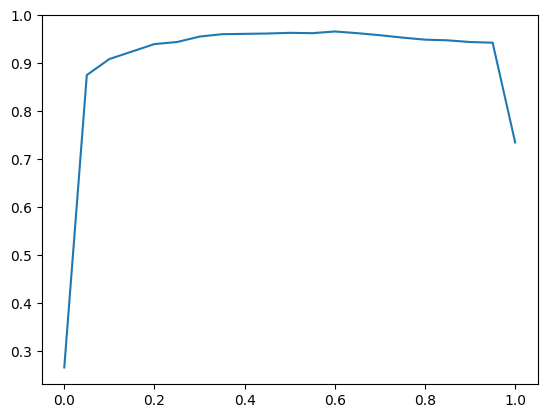

In [72]:
thresholds = np.linspace(0, 1, 21)

scores = []
for t in thresholds:
    churn_dec = y_pred >= t
    score = (y_val == churn_dec).mean()
    scores.append(score)

print(dict(zip(thresholds, scores)))

# Plot the thresholds vs. scores
plt.plot(thresholds, scores)

The best accuracy `(0.9659)` was achieved at threshold of `0.6`. 

**The dummy model**

You may notice that at 0 threshold the accuracy is 26.5% while at 1 the accuracy is 73.5%.

In [73]:
from collections import Counter

Counter(y_pred >= 1.0)

Counter({False: 1409})

What this is saying is that at threshold of 1.0, There are actually no values which are >= 1.0. If we are to compare `y_val == churn_decision`, (churn_decision = y_pred>= 1.0) it will be `True` for all values of y_val which are 0, because all the values of our `churn_decision` are 0's. This will be true **73.5%** of the time, which is also the distribution of 0's in our validation dataset. That's why we got this kind of accuracy.

This is called the `DUMMY MODEL`. On its own, it seems like a pretty decent model because of its good accuracy. But does accuracy really tell us the truth in this situation?

The problem with `acccuracy` is that it is misleading when applied to **IMBALANCED** dataset. You just based your predictions on what is the larger class. It cannot correctly evaluate a model which is trained in this kind of dataset.

**B. Confusion table**

* Different types of errors and correct decisions
* Arranging them in a table

In [74]:
def build_confusion_matrix(y_actual, y_prediction, t=0.5, normalize=False):
    actual_positive = y_actual == 1
    actual_negative = y_actual == 0

    predict_positive = y_prediction >= t
    predict_negative = y_prediction < t

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    confusion_matrix = np.array([[tn, fn], [fp, tp]])

    confusion_matrix_norm = (confusion_matrix / confusion_matrix.sum()).round(2)
    df_confusion_matrix = pd.DataFrame(
        confusion_matrix,
        columns=["True Negative", "True Positive"],
        index=["Predicted Negative", "Predicted Positive"],
    )

    if normalize == True:
        df_confusion_matrix_norm = pd.DataFrame(
            confusion_matrix_norm,
            columns=["True Negative", "True Positive"],
            index=["Predicted Negative", "Predicted Positive"],
        )
        return df_confusion_matrix_norm
    else:
        return df_confusion_matrix

**C. Precision, Recall, Specificity, F1 Score**

1. Precision - or `positive predictive value` tells us how much of **positive predictions** are actually correct

$$ precision = \frac {tp} {tp + fp} $$

2. Recall - or `true positive rate` or `sensitivity`, tells us how much of **actual positives** are predicted correctly.

$$ recall = \frac {tp} {tp + fn} $$

3. Specificity - or `true negative rate`, tells us how much of **actual negatives** are predicted correctly

$$ specificity = \frac {tn} {tn + fp} $$

4. F1-score - or `harmonic mean`, gives equal importance to both precision and recall.

* The general formula for f1-score, is where a positive real $\beta$ is chosen, such that recall is considered $\beta$ times as important as precision:

$$ F_{\beta} = (1 + \beta^{2}) \cdot \frac {precision\cdot recall} {(\beta^{2}\cdot precision) + recall} $$

* Thus, making $\beta = 1$ means precision is **as important** as recall. Giving us the final formula:

$$ F_{1} = 2 \cdot \frac {precision\cdot recall} {precision + recall} $$

**D. ROC Curves**

Here, we are interested about the `recall`, which is the **True Positive Rate**, and `1 - specificity`, which is the **False Positive Rate**.

FPR is the fraction of false positives (FP) divided by the total number of negatives (FP and TN - the first row of confusion matrix), and we want to `minimize` it.

On the other hand, TPR or Recall is the fraction of true positives (TP) divided by the total number of positives (FN and TP - second row of confusion table), and we want to `maximize` this metric. 

ROC (Receiver Operating Characteristic) Curve tells us about how good the model can distinguish between two things (e.g If a customer will churn or not). Better models can accurately distinguish between the two. Whereas, a poor model will have difficulties in distinguishing between the two.

The area under the ROC curve is known as AUC. The more the AUC the better your model is. The farther away your ROC curve is from the middle line (which is the random model), the better your model is. This is how ROC-AUC can help us judge the performance of our classification models as well as provide us a means to select one model from many classification models.

In [75]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []
    for t in thresholds:
        actual_positive = y_val == 1
        actual_negative = y_val == 0
        predict_positive = y_pred >= t
        predict_negative = y_pred < t

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ["threshold", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [76]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)
df_scores[::10]

threshold   tp    fp   fn    tn       tpr       fpr
0          0.0  374  1035    0     0  1.000000  1.000000
10         0.1  370   125    4   910  0.989305  0.120773
20         0.2  367    78    7   957  0.981283  0.075362
30         0.3  356    45   18   990  0.951872  0.043478
40         0.4  351    32   23  1003  0.938503  0.030918
50         0.5  342    20   32  1015  0.914439  0.019324
60         0.6  332     6   42  1029  0.887701  0.005797
70         0.7  318     3   56  1032  0.850267  0.002899
80         0.8  302     0   72  1035  0.807487  0.000000
90         0.9  295     0   79  1035  0.788770  0.000000
100        1.0    0     0  374  1035  0.000000  0.000000

**Random Model**

Let us simulate a random model which gives predictions just like flipping a coin.

In [77]:
np.random.seed(2)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [78]:
((y_rand >= 0.5) == y_val).mean()

0.5024840312278211

In [79]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand

threshold   tp    fp   fn    tn       tpr       fpr
0         0.00  374  1035    0     0  1.000000  1.000000
1         0.01  372  1024    2    11  0.994652  0.989372
2         0.02  368  1012    6    23  0.983957  0.977778
3         0.03  367  1000    7    35  0.981283  0.966184
4         0.04  364   995   10    40  0.973262  0.961353
..         ...  ...   ...  ...   ...       ...       ...
96        0.96   16    48  358   987  0.042781  0.046377
97        0.97   13    38  361   997  0.034759  0.036715
98        0.98    9    26  365  1009  0.024064  0.025121
99        0.99    4    10  370  1025  0.010695  0.009662
100       1.00    0     0  374  1035  0.000000  0.000000

[101 rows x 7 columns]

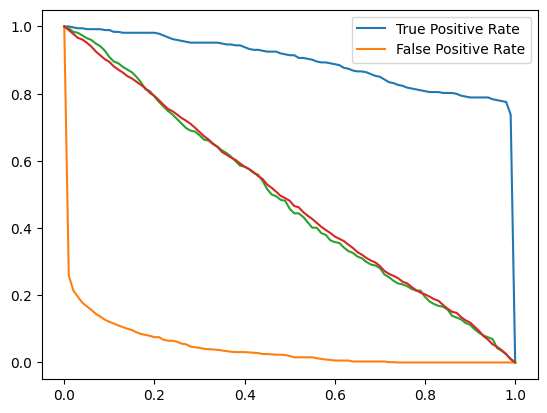

In [80]:
plt.plot(df_scores.threshold, df_scores["tpr"], label="True Positive Rate")
plt.plot(df_scores.threshold, df_scores["fpr"], label="False Positive Rate")


plt.plot(df_rand.threshold, df_rand["tpr"])
plt.plot(df_rand.threshold, df_rand["fpr"])
plt.legend()

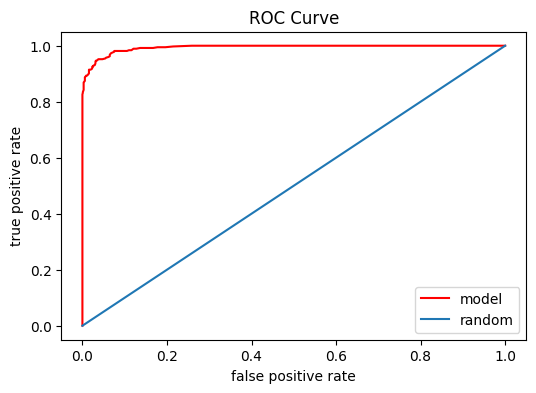

In [81]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.fpr, df_scores.tpr, color="red", label="model")
# plt.plot(df_rand.fpr, df_rand.tpr,color='yellow', label='random')
plt.plot([0, 1], [0, 1], label="random")
plt.legend()

plt.ylabel("true positive rate")
plt.xlabel("false positive rate")
plt.title("ROC Curve")

plt.show()

Using scikit-learn to draw the ROC Curve.

In [82]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

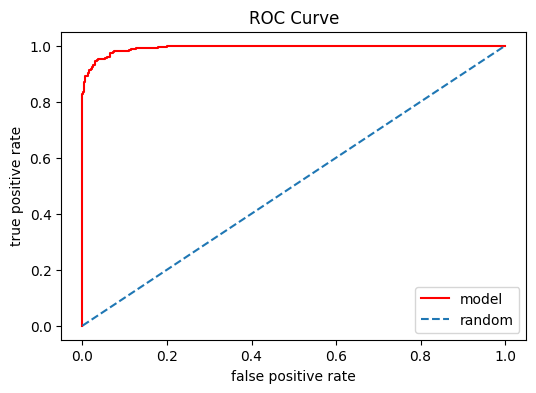

In [83]:
plt.figure(figsize=(6, 4))

plt.plot(fpr, tpr, color="red", label="model")
# plt.plot(df_rand.fpr, df_rand.tpr,color='yellow', label='random')
plt.plot([0, 1], [0, 1], label="random", linestyle="--")
plt.legend()

plt.ylabel("true positive rate")
plt.xlabel("false positive rate")
plt.title("ROC Curve")

plt.show()

**E. AUC Score**

* Area under the ROC curve
* interpretation of AUC

AUC tells us the probability that a randomly selected positive example has a higher score than a randomly selected negative example.

In [84]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.9935596372936526

In [85]:
auc(df_scores.fpr, df_scores.tpr)

0.9935777209434499

In [86]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.9935596372936526

**Implementing AUC Score in Python**

In [87]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [88]:
import random

n = 100000
success = 0
for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1
success / n

0.99417

**Implementing AUC score using numpy**

In [89]:
n = 100000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

((pos[pos_ind]) > (neg[neg_ind])).mean()

0.99371

**Summary of Model Performance Metrics**

In [90]:
def show_performance_metrics(y_actual, y_prediction, t=0.5, beta=1, n=100000):
    import random

    random.seed = 1

    actual_positive = y_actual == 1
    actual_negative = y_actual == 0

    predict_positive = y_prediction >= t
    predict_negative = y_prediction < t

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    # Negative predictions or predictions for actual negative values
    neg = y_prediction[y_actual == 0]
    # Positive predictions or predictions for actual positive values
    pos = y_prediction[y_actual == 1]

    success = 0
    for i in range(n):
        pos_ind = random.randint(0, len(pos) - 1)
        neg_ind = random.randint(0, len(neg) - 1)
        # checks if positive predictions are truly greater than negative predictions
        if pos[pos_ind] > neg[neg_ind]:
            success += 1

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    fbeta_score = (1 + beta**2) * (
        (precision * recall) / ((beta**2 * precision) + recall)
    )
    auc_score = success / n
    cohen_kappa = cohen_kappa_score(y_actual, (y_prediction >= t).astype(int))
    prc_score = average_precision_score(y_actual, (y_prediction >= t).astype(int))

    df_performance_metrics = pd.DataFrame(
        [
            accuracy,
            precision,
            recall,
            specificity,
            fbeta_score,
            auc_score,
            cohen_kappa,
            prc_score,
        ],
        index=[
            "accuracy",
            "precision",
            "recall",
            "specificity",
            f"f{beta} score",
            "auc score",
            "cohen_kappa",
            "prc score",
        ],
        columns=["score"],
    )

    return df_performance_metrics

In [91]:
# Since our goal is to minimize the false negatives, ie. lessen those people who will actually churn but predicted to not churn
# Let's compare our recall scores for three thresholds

best_recall = 0
best_threshold = 0
for i in [0.45, 0.5, 0.55]:
    best_score = recall_score(y_val, (y_pred >= i).astype(int))
    print(f"{i}: {best_score}")
    if best_score > best_recall:
        best_recall = best_score
        best_threshold = i

best_threshold

0.45: 0.9251336898395722
0.5: 0.9144385026737968
0.55: 0.9010695187165776


0.45

In [92]:
# Validation set performance metrics
show_performance_metrics(y_val, y_pred, t=best_threshold)

score
accuracy     0.961675
precision    0.930108
recall       0.925134
specificity  0.974879
f1 score     0.927614
auc score    0.993370
cohen_kappa  0.901552
prc score    0.880346

In [93]:
# Validation predictions confusion matrix
build_confusion_matrix(y_val, y_pred, t=best_threshold)

True Negative  True Positive
Predicted Negative           1009             28
Predicted Positive             26            346

In [94]:
# Test set performance metrics
show_performance_metrics(y_test, y_pred_test, t=best_threshold)

score
accuracy     0.963094
precision    0.937500
recall       0.922460
specificity  0.977778
f1 score     0.929919
auc score    0.993180
cohen_kappa  0.904873
prc score    0.885388

In [95]:
# Test predictions confusion matrix
build_confusion_matrix(y_test, y_pred_test, t=best_threshold)

True Negative  True Positive
Predicted Negative           1012             29
Predicted Positive             23            345

Our final logistic model has a recall score of **92.25%** on the test set. It can predict customer records ***out of sample*** with a fairly high but still imperfect recall score.

In the tables below, we know that `satisfaction_score` has the highest mutual information score among all categorical features. We want to inspect at what satisfaction score will our model perform worst.

In [96]:
t = 0.45
val_sat_score = X_val[:, 24]
df_val_sat_score_churn = pd.DataFrame()
df_val_sat_score_churn["satisfaction_score"] = val_sat_score
df_val_sat_score_churn["actual"] = y_val
df_val_sat_score_churn["prediction"] = (y_pred >= t).astype(int)
df_val_sat_score_churn["correct"] = (y_pred >= t).astype(int) == y_val
df_val_sat_score_churn

satisfaction_score  actual  prediction  correct
0                    1.0       1           1     True
1                    3.0       0           0     True
2                    4.0       0           0     True
3                    5.0       0           0     True
4                    5.0       0           0     True
...                  ...     ...         ...      ...
1404                 3.0       0           0     True
1405                 5.0       0           0     True
1406                 3.0       1           1     True
1407                 3.0       1           1     True
1408                 3.0       0           0     True

[1409 rows x 4 columns]

In [97]:
df_grouped_val_sat_score = df_val_sat_score_churn.groupby("satisfaction_score")[
    "correct"
].mean()
df_grouped_val_sat_score

satisfaction_score
1.0    1.000000
2.0    1.000000
3.0    0.898496
4.0    1.000000
5.0    1.000000
Name: correct, dtype: float64

With our validation set, our model correctly predicted the churn values of all customers with satisfaction scores of **1, 2, 4, & 5**. With those customers giving a satisfaction score of **3**, here is where our model generated those false predictions, only having an 89.85% accuracy.

In [98]:
test_sat_score = X_test[:, 24]
df_test_sat_score_churn = pd.DataFrame()
df_test_sat_score_churn["satisfaction_score"] = test_sat_score
df_test_sat_score_churn["actual"] = y_test
df_test_sat_score_churn["prediction"] = (y_pred_test >= t).astype(int)
df_test_sat_score_churn["correct"] = (y_pred_test >= t).astype(int) == y_test
df_test_sat_score_churn

satisfaction_score  actual  prediction  correct
0                    5.0       0           0     True
1                    1.0       1           1     True
2                    4.0       0           0     True
3                    4.0       0           0     True
4                    4.0       0           0     True
...                  ...     ...         ...      ...
1404                 3.0       0           0     True
1405                 5.0       0           0     True
1406                 1.0       1           1     True
1407                 4.0       0           0     True
1408                 3.0       0           0     True

[1409 rows x 4 columns]

In [99]:
df_grouped_test_sat_score = df_test_sat_score_churn.groupby("satisfaction_score")[
    "correct"
].agg(["count", "mean"])
df_grouped_test_sat_score

count      mean
satisfaction_score                 
1.0                   188  1.000000
2.0                   102  1.000000
3.0                   526  0.901141
4.0                   352  1.000000
5.0                   241  1.000000

A similar result was found with the test set. Our model only failed to predict all records correctly for those customers who gave a satisfaction score of 3, at which it achieved 90.11% accuracy.

##### **X. Saving the data processors, best threshold, and model**

In [100]:
# Save the threshold to disk
threshold_file = "threshold.sav"
joblib.dump(best_threshold, threshold_file)

['threshold.sav']

In [101]:
# Save the model to disk
model_file = "model.sav"
joblib.dump(model_full_train, model_file)

['model.sav']

In [102]:
# Saving our MinMaxScaler to disk
scaler_file = "scaler.sav"
joblib.dump(full_train_scaler, scaler_file)

['scaler.sav']

In [103]:
# Saving our DictVectorizer to disk
vect_file = "dictvectorizer.sav"
joblib.dump(dv_full_train, vect_file)

['dictvectorizer.sav']

##### **End. Thank you!**